In [1]:
import numpy as np
import torch

In [2]:
from models import MPS, ComplexTensor

In [59]:
L=4
local_dim=2
bond_dim=10

In [60]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [61]:
fname_settings="settings_ghz_plus_all_discrete_bases_angles_L=4.npy"
fname_samples="samples_ghz_plus_all_discrete_bases_angles_L=4.npy"
samples = np.load(fname_samples)
samples_tr = torch.tensor((samples + 1)/2).to(torch.long)
settings = np.load(fname_settings)

In [62]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

In [63]:
from qtools import pauli_exp

In [64]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [65]:
from torch.utils.data import TensorDataset, DataLoader

In [66]:
from models import MeasurementDataset, ComplexTensor

In [67]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)

In [68]:
batch_size = 1024
lr = .001

In [69]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [70]:
losses = []

In [71]:
eps = 1

In [72]:
def sgd_step_at_site(mps, site_index, spin_config,
                         rotation=None, cutoff=1e-10, normalize='left'):
    """Perform SGD step WRT two-site blob with left index at the site specified"""
    psi.gauge_to(site_index)
    #two-site blob matrix at the site
    A = psi.merge(i).numpy()
    #gradient of the log-prob WRT that complex matrix
    #note that A has to updated from the conjugate!
    g=psi.grad_twosite_logprob(i, spin_config,rotation=rotation).numpy().conj()
    #perform gradient descent step, insert back into MPS
    A = A - 2 * lr * g
    psi.set_sites_from_twosite(i, A,cutoff=cutoff,normalize='left')
   

In [73]:
for ep in range(eps):
    for step, inputs in enumerate(dl):
        spinconfig = inputs['samples']
        rot = inputs['rotations']
        rotations = ComplexTensor(rot['real'], rot['imag'])
        for i in range(L-1):
            sgd_step_at_site(psi, i, spinconfig,
                                    rotation=rotations,cutoff=1e-10,normalize='left')   
        for i in range(L-2, -1,-1):
            sgd_step_at_site(psi, i, spinconfig,
                                 rotation=rotations, cutoff=1e-10,normalize='right')
        with torch.no_grad():
            losses.append(psi.nll_loss(spinconfig,rotation=rotations))
    print("finished epoch %d" % ep)

        

finished epoch 0


In [74]:
import matplotlib.pyplot as plt

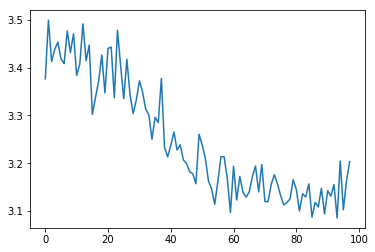

In [75]:
%matplotlib inline
plt.plot(losses)

In [76]:
from tools import generate_binary_space

In [77]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [78]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1, 1, 1]) has probability 0.0426
tensor([1, 1, 1, 0]) has probability 0.0256
tensor([1, 1, 0, 1]) has probability 0.0237
tensor([1, 1, 0, 0]) has probability 0.0062
tensor([1, 0, 1, 1]) has probability 0.0754
tensor([1, 0, 1, 0]) has probability 0.2767
tensor([1, 0, 0, 1]) has probability 0.0529
tensor([1, 0, 0, 0]) has probability 0.0601
tensor([0, 1, 1, 1]) has probability 0.0826
tensor([0, 1, 1, 0]) has probability 0.0720
tensor([0, 1, 0, 1]) has probability 0.0942
tensor([0, 1, 0, 0]) has probability 0.0440
tensor([0, 0, 1, 1]) has probability 0.0169
tensor([0, 0, 1, 0]) has probability 0.0657
tensor([0, 0, 0, 1]) has probability 0.0317
tensor([0, 0, 0, 0]) has probability 0.0296
